# Graph Dataset Loading and Batching
---

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import torch
from os import path

import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7,7) # use larger for presentation
matplotlib.rcParams['font.size']= 12 # use 14 for presentation

In [10]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.transforms as T

from simgnn.datasets import VertexDynamics, HaraMovies, CellData
from simgnn.transforms import Pos2Vec, ScaleVelocity

In [11]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cpu
 |-dtype : torch.float32


## Amnioserosa Movies (Y. Hara dataset)

- `*Seg*.tif` files: segmented boundary image stacks (movies)
- To-do: function for converting edges and node2cell edges to `vertex_simulation` cell format --> "Cells": dict of lists,<br>
`{ cell_i : [e in 1:Ne and "-e"==reversed order of verts ] }`.

In [12]:
import glob
from simgnn.hara import get_cell_colormap, read_tiff_stack

from simgnn.datautils import write_array, mknewdir
from simgnn.hara import label_bw_stack, extract_graph

In [13]:
base_path = path.abspath('../../../dataDIR/example_segmented_data/')

print('RFP channels (cell boundary):')
rfp = {path.basename(path.dirname(fname)) : read_tiff_stack(fname) 
       for fname in glob.glob(path.join(base_path,'*Seg*','*RFP*.tif'))}
print('Segmented boundaries:')
seg = {path.basename(path.dirname(fname)) : read_tiff_stack(fname) 
       for fname in glob.glob(path.join(base_path,'*Seg*','*Seg*.tif'))}

RFP channels (cell boundary):
Image stack shape: (61, 512, 511) -- trim boundaries: True
Image stack shape: (61, 512, 511) -- trim boundaries: True
Image stack shape: (61, 512, 511) -- trim boundaries: True
Segmented boundaries:
Image stack shape: (61, 512, 511) -- trim boundaries: True
Image stack shape: (61, 512, 511) -- trim boundaries: True
Image stack shape: (61, 512, 511) -- trim boundaries: True


### Extract Graphs from Amnioserosa Movies

In [14]:
root_dir = 'simgnn_data/hara_movies/raw/'
PROCESS_HARA_MOVIE = False # set to true to process Hara AS tissue movies

if PROCESS_HARA_MOVIE:
    for bw_img in seg:
        edges_index, node2cell_index, v_pos = extract_graph(seg[bw_img], label_bw_stack(seg[bw_img])[0])
        edge_lengths = np.sqrt(((v_pos[:,edges_index[1],:] - v_pos[:,edges_index[0],:])**2).sum(axis=-1,keepdims=True))

        dataDir = path.join(root_dir, bw_img)
        mknewdir(dataDir);

        write_array(path.join(dataDir, 'edges_index.npy'), edges_index)
        write_array(path.join(dataDir, 'node2cell_index.npy'), node2cell_index)
        write_array(path.join(dataDir, 'vtx_pos.npy'), v_pos)
        write_array(path.join(dataDir, 'edge_Length.npy'), edge_lengths)

In [24]:
# !ls 'simgnn_data/hara_movies/raw/Seg_001/'

### Drawing AS Movie Graphs

In [10]:
DRAW_GRAPH = True
DRAW_GRAY = True
def draw_frame(t):
    if DRAW_GRAY:
        plt.imshow(rfp[SAMPLE_NAME][t],cmap='gray_r');
    if DRAW_GRAPH:
        # edges
        for e in edges_index.T:
            plt.plot(v_pos[t,e,0],v_pos[t,e,1], color='turquoise', lw=5,alpha=.6)
        # vertices
        plt.plot(v_pos[t,:,0], v_pos[t,:,1],'o',color='purple', alpha=.5,ms=8)
    
#     plt.plot(v_pos[t,edges_index[:,14],0], v_pos[t,edges_index[:,14],1],'o-', color='orangered', ms=10)
#     plt.plot(v_pos[t,edges_index[:,119],0], v_pos[t,edges_index[:,119],1],'o-', color='indigo', ms=10)
#     plt.plot(v_pos[t,edges_index[:,147],0], v_pos[t,edges_index[:,147],1],'o-', color='dodgerblue', ms=10)
    
    # axis limits
    plt.title(f"t= {t/6:4.1f} min")
    plt.axis(False);
    plt.axis((-0.5, 510.5, 511.5, -0.5));

In [8]:
SAMPLE_NAME = 'Seg_001'
root_dir = '../../../dataDIR/simgnn_data/hara_movies'
dataDir = path.join(root_dir, SAMPLE_NAME)

edges_index = load_array(path.join(dataDir, 'edges_index.npy'))
node2cell_index = load_array(path.join(dataDir, 'node2cell_index.npy'))
v_pos = load_array(path.join(dataDir, 'vtx_pos.npy'))
eij_lens = load_array(path.join(dataDir, 'edge_Length.npy'))

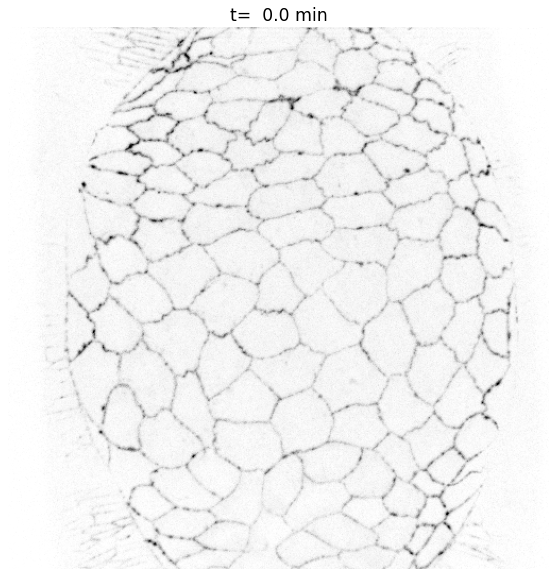

In [11]:
plt.figure(figsize=[10,10])
DRAW_GRAY = True; DRAW_GRAPH = False; t = 0;

draw_frame(t);
# e_id = 147
# plt.plot(v_pos[t,edges_index[:,e_id],0], v_pos[t,edges_index[:,e_id],1],'o-', color='dodgerblue', ms=10)
plt.show()

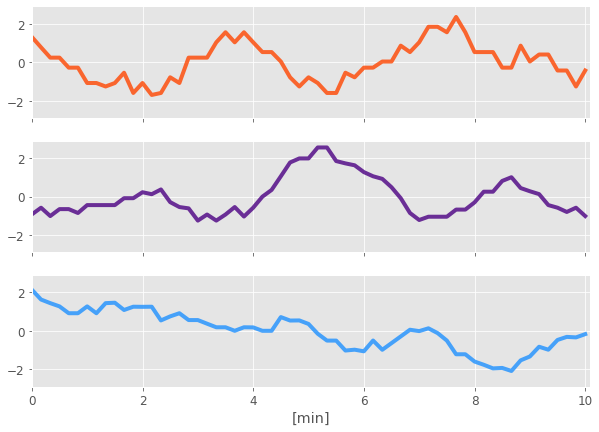

In [22]:
fig,axs = plt.subplots(nrows=3,ncols=1,sharex=True,sharey=True, figsize=[10,7])
t = np.arange(eij_lens.shape[0])/6
for ax,e_id,c in zip(axs,  [14, 119, 147], ['orangered', 'indigo', 'dodgerblue']):
    ax.plot(t,(eij_lens[:,e_id]-eij_lens[:,e_id].mean())/eij_lens[:,e_id].std(), lw=4, alpha=.8, color = c);#normalised lengths over time
ax.axis([0,60.5/6,-2.9,2.9])
ax.set_xlabel('[min]')
plt.show()

In [34]:
ls '../../../dataDIR/simgnn_data/train/raw/17Nov2020/simul_Length.npy'

graph_dict.pkl*        simul_Kp.npy*          simul_Perimeter.npy*
simul_A0.npy*          simul_Lambda_ij.npy*   simul_t.npy*
simul_Area.npy*        simul_Length.npy*      simul_vtxpos.npy*
simul_Ka.npy*          simul_P0.npy*          t_Energy_maxSpeed.npy*


### Save AS Movie Graphs

In [190]:
import PIL

pil_images =[]
DRAW_GRAPH = False
DRAW_GRAY = True
for i in range(0,rfp[SAMPLE_NAME].shape[0]):
    fig = plt.figure(figsize=[10,10],dpi=60)
    fig.clf(); ax = fig.subplots();
    draw_frame(i)
    
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    pil_images.append(PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb()) )
    plt.close()

In [131]:
print(len(pil_images),'; pil0:',pil_images[0].size, '; pil_last', pil_images[-1].size)

61 ; pil0: (600, 600) ; pil_last (600, 600)


In [191]:
# duration:duration of each frame [s]
# loop : loop the video, see options
pil_images[0].save('./gray_oscillations.gif', format='GIF',
                  append_images=pil_images[1::3], save_all=True, duration=150, loop=0)

### Compare with Simulated Edges

In [181]:
sim_Data_Dir = '../../../dataDIR/simgnn_data/train/raw/17Nov2020/'
sim_eij_lens = load_array(path.join(sim_Data_Dir, 'simul_Length.npy'))
sim_t = load_array(path.join(sim_Data_Dir, 'simul_t.npy'))
verts_t = load_array(path.join(sim_Data_Dir, 'simul_vtxpos.npy'))
sim_Graph = load_graph(path.join(sim_Data_Dir, 'graph_dict.pkl'))

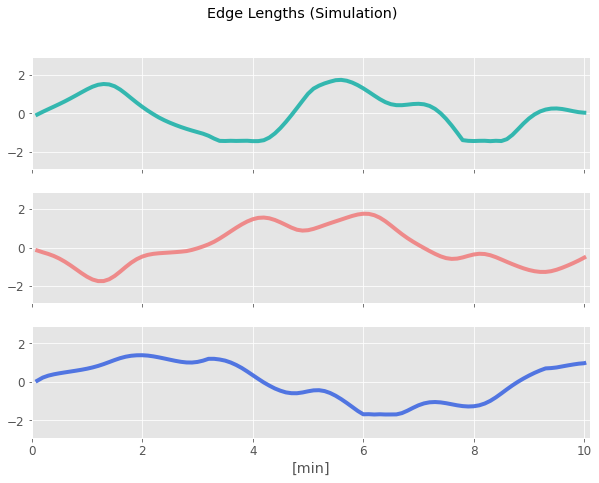

In [182]:
fig,axs = plt.subplots(nrows=3,ncols=1,sharex=True,sharey=True, figsize=[10,7])

for ax,e_id,c in zip(axs,  [65, 115,30], ['lightseagreen', 'lightcoral', 'royalblue']):
    ax.plot(sim_t,(sim_eij_lens[:,e_id,0] - sim_eij_lens[:,e_id,0].mean())/sim_eij_lens[:,e_id,0].std(),
            lw=4, alpha=.9, color = c);#normalised lengths over time
ax.axis([0,10.1,-2.9,2.9])
ax.set_xlabel('[min]')
plt.suptitle('Edge Lengths (Simulation)')
plt.show()

In [183]:
import networkx as nx
from vertex_simulation.primitives import Vertex, Monolayer, graph2networkx_with_pos, Monolayer

# as a networkx graph
m = Monolayer(vertices=Vertex(verts_t[0]), edges=torch.tensor(sim_Graph['edges'],dtype=torch.long), cells=sim_Graph['cells'])
Gnx,pos=graph2networkx_with_pos(m)
def draw_graph(i):
    '''Draw monolayer frames using networkx draw func-n. Assumes. Static graph, i.e. the graph `Gnx` is constant.
    We pass this function to matplotlib.animation obj.'''
    if isinstance(verts_t[i],  torch.Tensor):
        pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i].numpy()))
    else:
        pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i]))
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Time : {sim_t[i]:5.1f} mins',fontsize=50)
    nx.draw(Gnx,pos,node_size=20,width=8,ax=ax,node_color='#FF00FF',edge_color='silver')

In [184]:
import PIL
pil_images=[]
for i in range(0,len(verts_t),2):
    fig = plt.figure(figsize=[15,15],dpi=40)
    fig.clf()
    ax = fig.subplots()
    ax.axis(False);
    draw_graph(i)
    for e_ij_x, c in zip(verts_t[i,m.edges[[65, 115,30]],:], ['lightseagreen', 'lightcoral', 'royalblue']):
        plt.plot(e_ij_x[:,0],e_ij_x[:,1],'o-',color=c,ms=15,lw=10)
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    pil_images.append(PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb()) )
    plt.close()
# duration:duration of each frame [s] || loop : loop the video, see options
pil_images[0].save('./sim_oscill_10x10_labeled_edges.gif', format='GIF',
               append_images=pil_images[1:], save_all=True, duration=150, loop=0)

## Synthetic Dataset and PyTorch Geometric

---
Edge (Line) **TENSION** and cell **PRESSURE** attributes

- Edge tensions
$$T_{edge:(i,j)} = \Lambda_{ij}(t)+\sum_{k\in\{cells\ for\ (i,j)\}}K_p^{(k)}(p^{(k)}-p_0^{(k)})$$
- Cell pressures
$$\pi_{cell:k} = -2K_a^{(k)}(a^{(k)}-a_0^{(k)})$$

---
**Adding noise from M steps**: Sum of M normal rand. var-s results in normal var. w/ variance M and s.t.d.=sqrt(M):
```python
x = np.random.normal(size=(5,1000))
y = x.sum(axis=0)
z = np.random.normal(size=(1,1000))*np.sqrt(5)
plt.hist(x.ravel(),bins=50,label='x',density=True)
plt.hist(y        ,bins=50,label='y',density=True)
plt.hist(z.ravel(),bins=50,label='z',density=True,alpha=.5)
plt.legend();
```

---

- **Node features** : velocities from previous frames (~ 5 frames--> Alvaro Sanchez-Gonzalez, *et al.* 2020 \[ASG2020\])
- **Edge features** : can use edge directions (optional, might help to speed up training)
- **Current position** : technically a node feature, and needs to be normalized but not processed by the network.
- Positions (Cartesian) to polar edge attributes: `transforms.Polar` \[[link](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.Polar)\], I can also implement or use the `transforms.Cartesian` which computes direction vectors (position pairs -to- normalized direction vectors).
- need transform for velocity noise (use src from example transforms above and ASG2020 paper)
- Train-g movie: max edge length ~ 3.25 a.u.

- `simgnn.datasets.VertexDynamics` (child of `torch_geometric.data.Dataset`)

In [25]:
Tnorm = T.Compose([Pos2Vec(scale=20*0.857) ,
                           ScaleVelocity(0.857)])

vtxdata = VertexDynamics('../../../dataDIR/simgnn_data/train/', transform=Tnorm)
vtxdata

Processing...
Done!


VertexDynamics(95)

In [26]:
data=vtxdata[0]

In [27]:
data

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_attr=[339, 2], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

In [17]:
# e_x = torch.cat([d.edge_attr for d in vtxdata],0)
# print(f'> Edge attr\n\trange: [{e_x.min():4.3g} {e_x.max():4.3g}]; s.d.: {e_x.std():4.3g} ||'+
#       f' median: {e_x.median():4.3g}; mean: {e_x.mean():4.3g};')
# plt.hist(e_x.view(-1,).numpy(),bins=30); plt.title('Edge Vec-s(norm)');

In [28]:
loader = DataLoader([vtxdata[0], vtxdata[25]], batch_size=2)
batch = next(iter(loader))
print(batch)
# nx.draw(to_networkx(batch, to_undirected=True),pos=dict(enumerate(batch.pos.numpy())), node_size=60)

Batch(batch=[480], cell2node_index=[2, 1200], cell_pressures=[200], edge_attr=[678, 2], edge_index=[2, 678], edge_tensions=[678], node2cell_index=[2, 1200], pos=[480, 2], x=[480, 5, 2], y=[480, 2])


In [10]:
# data = vtxdata[0]
# print(data)
# plt.figure(figsize=[10,10])
# plt.title('Monolayer Graph with Cell-to-Nodes Edges')
# nx.draw(to_networkx(data), pos=dict(enumerate(data.pos.numpy())), node_size=30)
# for ci in range(data.num_cells):
#     c_vxpos = data.pos[data.node2cell_index[0][data.node2cell_index[1]==ci]]
#     cpos = c_vxpos.mean(dim=0)
#     for vi in c_vxpos:
#         plt.plot([vi[0],cpos[0]],[vi[1],cpos[1]],lw=3,alpha=.5)
#     plt.plot(cpos[0],cpos[1],'bo',ms=10,alpha=.5)
# # plt.savefig('cell2node.png',dpi=100)

In [85]:
# cell_pos = np.stack([d1.pos[d1.cell2node_index[1,d1.cell2node_index[0]==c]].mean(dim=0).numpy() for c in range(d1.num_cells)])
# plt.figure(figsize=[20,20])
# nx.draw(to_networkx(d1),pos=dict(enumerate(d1.pos.numpy())), node_size=60)
# plt.plot(cell_pos[:,0],cell_pos[:,1],'ro',ms=10, alpha=.5)
# for c, c_pos in enumerate(cell_pos):
#     plt.text(c_pos[0],c_pos[1], f'{d1.cell_pressures[c]:.3f}') 

In [21]:
# t=5
# Dt = 1
# # plt.figure(figsize=[25,25])
# nx.draw(to_networkx(vtxdata[t], to_undirected=True),pos=dict(enumerate(vtxdata[t].pos.numpy())), node_size=60)
# nx.draw(to_networkx(vtxdata[t+Dt], to_undirected=True),pos=dict(enumerate(vtxdata[t+Dt].pos.numpy())),
#         node_size=20,width=4,
#         node_color='#FF00FF',edge_color='#51C5FF',alpha=.5)
# plt.quiver(vtxdata[t].pos.numpy()[:,0], vtxdata[t].pos.numpy()[:,1],
#            vtxdata[t].y.numpy()[:,0],vtxdata[t].y.numpy()[:,1],
#            units='xy',angles='xy',scale=.25,color='r')

In [24]:
# Compare computed and original *edge lengths*
# dist_fn = T.Distance(norm=False)
# compute cartesian distances
# dist_fn(data);

## Data Normalisation

**Length unit** = average edge length (over whole dataset)
- divide all "edge lengths", node "speeds" and "velocities" by mean edge length $l_0$, this measures all len-s in $l_0$ units. 
- the real and the simulation datasets each will have its own average len. : $l^{(real)}_0$ and $l^{(sim)}_0$

**Normalisation** <br>
Normalising lengths, velocities (and areas) requires speacial considerations, since relative edge lengths and node vel-s are inputs to the GNN model and need to be same for the *simulated* and the *real* datasets.
- `[ data.edge_attr ]` *edge directions* $e_i$, and *edge lens* $l_i$: since lengths are in range `[0, l_max]`, scale by 20 average lengths and no mean shift to zero. We get
$$l^{norm}_i = \frac{l_i}{20\cdot{}l_0}$$
this scales lengths to values comparable to node velocity magnitudes which are about 1/20's of length or 5% of $l_0$ (do the same for $e^{norm}_i$).
- `[ data.x, data.y ]` *node velocities* $\Delta{}v_i$: scale by one average edge length, $$\Delta{}v_i^{norm} = \frac{\Delta{}v_i}{l_0}$$
this applies to both *node attributes and targets*.

- `l_0 = 0.857 (average edge length, simulated data)`

In [40]:
vtxdata = VertexDynamics('../../../dataDIR/simgnn_data/train/')
vtxdata[0]

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

In [41]:
Tnorm = T.Compose([Pos2Vec(scale=20*0.857) ,
                           ScaleVelocity(0.857)]) # data normalisation
vtxdata_norm = VertexDynamics('../../../dataDIR/simgnn_data/train/',transform=Tnorm)
vtxdata_norm[0]

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_attr=[339, 2], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

In [42]:
data = vtxdata[0]
data

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_index=[2, 339], edge_tensions=[339], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

> Edge len
	range: [2.86e-06 3.27]; s.d.:  0.5 || median: 0.875; mean: 0.857;
> Node speed
	range: [1.35e-05 0.147]; s.d.: 0.019 || median: 0.024; mean: 0.0281;
Edge vect-s
	range: [-3.25 2.62]; s.d.: 0.702 || median: -0.000488; mean: -0.0101;
Node velocity
	range: [-0.134 0.139]; s.d.: 0.024 || median: 0.000116; mean: 6.56e-09;
Edge vect-s (transform)
	range: [-0.19 0.153]; s.d.: 0.0409 || median: -2.85e-05; mean: -0.000588;
Node velocity (transform)
	range: [-0.157 0.162]; s.d.: 0.028 || median: 0.000136; mean: 7.69e-09;


Text(0.5, 1.0, '(Raw) Node vel-s')

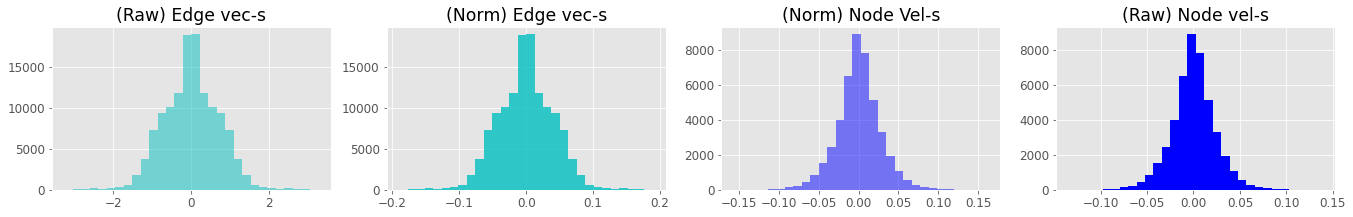

In [97]:
v_vel = torch.cat([d.y for d in vtxdata],0)
e_vec = torch.cat([(d.pos[d.edge_index[1]]-d.pos[d.edge_index[0]]) for d in vtxdata],0)

v_spd = v_vel.pow(2).sum(dim=1).sqrt()
e_len = e_vec.pow(2).sum(dim=1).sqrt()

print(f'> Edge len\n\trange: [{e_len.min():4.3g} {e_len.max():4.3g}]; s.d.: {e_len.std():4.3g} ||'+
      f' median: {e_len.median():4.3g}; mean: {e_len.mean():4.3g};')
print(f'> Node speed\n\trange: [{v_spd.min():4.3g} {v_spd.max():4.3g}]; s.d.: {v_spd.std():4.3g} ||'+
      f' median: {v_spd.median():4.3g}; mean: {v_spd.mean():4.3g};')

print(f'Edge vect-s\n\trange: [{e_vec.min():4.3g} {e_vec.max():4.3g}]; s.d.: {e_vec.std():4.3g} ||'+
      f' median: {e_vec.median():4.3g}; mean: {e_vec.mean():4.3g};')
print(f'Node velocity\n\trange: [{v_vel.min():4.3g} {v_vel.max():4.3g}]; s.d.: {v_vel.std():4.3g} ||'+
      f' median: {v_vel.median():4.3g}; mean: {v_vel.mean():4.3g};')

# After transforms (normalisation and scaling)
v_vel2 = torch.cat([d.y for d in vtxdata_norm],0)
e_vec2 = torch.cat([d.edge_attr for d in vtxdata_norm],0)

print(f'Edge vect-s (transform)\n\trange: [{e_vec2.min():4.3g} {e_vec2.max():4.3g}]; s.d.: {e_vec2.std():4.3g} ||'+
      f' median: {e_vec2.median():4.3g}; mean: {e_vec2.mean():4.3g};')
print(f'Node velocity (transform)\n\trange: [{v_vel2.min():4.3g} {v_vel2.max():4.3g}]; s.d.: {v_vel2.std():4.3g} ||'+
      f' median: {v_vel2.median():4.3g}; mean: {v_vel2.mean():4.3g};')

plt.figure(figsize=[23,3])
ax1 = plt.subplot(1,4,1)
ax1.hist(np.concatenate([e_vec.view(-1,).numpy(), -e_vec.view(-1,).numpy()]),bins=30,color='c',alpha=.5);
ax1.set_title('(Raw) Edge vec-s')

ax2 = plt.subplot(1,4,2)
ax2.hist(np.concatenate([e_vec2.view(-1,).numpy(), -e_vec2.view(-1,).numpy()]),bins=30,color='c',alpha=.8);
ax2.set_title('(Norm) Edge vec-s')

ax3 = plt.subplot(1,4,3, sharex=ax3)
ax3.hist(v_vel2.view(-1,).numpy(),bins=30,color='b',alpha=.5);
ax3.set_title('(Norm) Node Vel-s');

ax4 = plt.subplot(1,4,4)
ax4.hist(v_vel.view(-1,).numpy(),bins=30,color='b');
ax4.set_title('(Raw) Node vel-s')

> Cell Pressures
	range: [-0.069 2.41]; s.d.:  0.4 || median: 1.05; mean: 1.06;
> Edge Tensions
	range: [0.0167 3.83]; s.d.: 0.53 || median: 1.32; mean: 1.42;


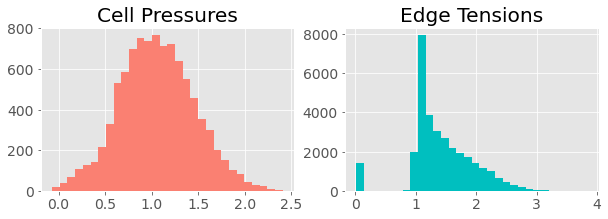

In [115]:
c_pres = torch.cat([d.cell_pressures for d in vtxdata],0)
e_tens = torch.cat([d.edge_tensions for d in vtxdata],0)

print(f'> Cell Pressures\n\trange: [{c_pres.min():4.3g} {c_pres.max():4.3g}]; s.d.: {c_pres.std():4.3g} ||'+
      f' median: {c_pres.median():4.3g}; mean: {c_pres.mean():4.3g};')
print(f'> Edge Tensions\n\trange: [{e_tens.min():4.3g} {e_tens.max():4.3g}]; s.d.: {e_tens.std():4.3g} ||'+
      f' median: {e_tens.median():4.3g}; mean: {e_tens.mean():4.3g};')

plt.figure(figsize=[10,3])
ax1 = plt.subplot(1,2,1)
ax1.hist(c_pres.view(-1,).numpy(),bins=30,color='salmon');
ax1.set_title('Cell Pressures')

ax2 = plt.subplot(1,2,2)
ax2.hist(e_tens.view(-1,).numpy(),bins=30,color='c');
ax2.set_title('Edge Tensions');

In [16]:
Tnorm

Compose([
    Pos2Vec(norm=True, scale=17.14, cat=False),
    ScaleVelocity(scale=0.857),
])

In [99]:
SAMPLE_NAME = 'Seg_001'
root_dir = '../../../dataDIR/simgnn_data/hara_movies'
dataDir = path.join(root_dir, SAMPLE_NAME)

edges_index = load_array(path.join(dataDir, 'edges_index.npy'))
node2cell_index = load_array(path.join(dataDir, 'node2cell_index.npy'))
v_pos = load_array(path.join(dataDir, 'vtx_pos.npy'))
eij_lens = load_array(path.join(dataDir, 'edge_Length.npy'))
# l_Re_0 = eij_lens.mean()

In [100]:
e_vec2_Re = v_pos[:,edges_index[1],:] - v_pos[:,edges_index[0],:]
e_vec2_Re_norm = e_vec2_Re/(26.32*20)

v_vel_Re = np.diff(v_pos,axis=0)
v_vel_Re_norm = v_vel_Re/(26.32)

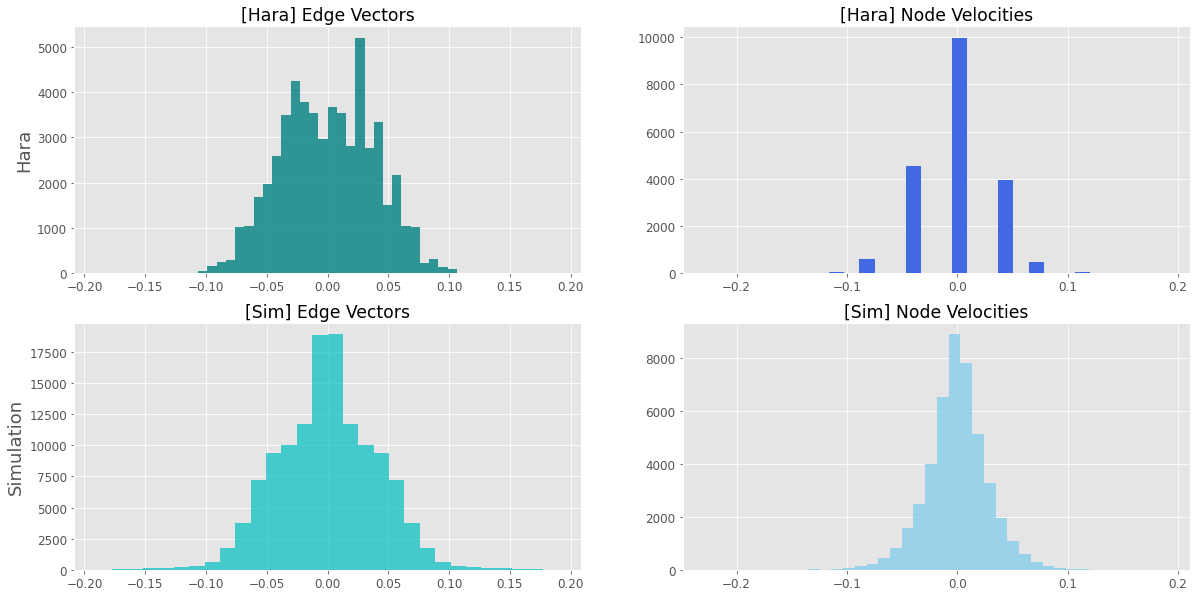

In [129]:
plt.figure(figsize=[20,10])
ax1 = plt.subplot(2,2,1)
ax1.hist(np.concatenate([e_vec2_Re_norm.ravel(),-e_vec2_Re_norm.ravel()]),bins=30,color='teal',alpha=.8);
ax1.set_title('[Hara] Edge Vectors')
ax1.set_ylabel('Hara',fontdict={'fontsize':18})

ax2 = plt.subplot(2,2,2)
ax2.hist(v_vel_Re_norm.ravel(),bins=30,color='royalblue');
ax2.set_title('[Hara] Node Velocities');

ax3 = plt.subplot(2,2,3,sharex=ax1)
ax3.hist(np.concatenate([e_vec2.view(-1,).numpy(), -e_vec2.view(-1,).numpy()]),bins=30,color='c',alpha=.7);
ax3.set_title('[Sim] Edge Vectors')
ax3.set_ylabel('Simulation',fontdict={'fontsize':18})

ax4 = plt.subplot(2,2,4, sharex=ax2)
ax4.hist(v_vel2.view(-1,).numpy(),bins=30,color='skyblue',alpha=.8);
ax4.set_title('[Sim] Node Velocities');

Same normalised Hara movies dataset using `HaraMovies` graph dataset implementation

In [15]:
T_hara_movie_norm = T.Compose([Pos2Vec(scale=20*26.32) ,
                           ScaleVelocity(26.32)]) # data normalisation
hara_movs = HaraMovies('simgnn_data/hara_movies/', transform=T_hara_movie_norm)

Hara movie dataset:
- - - - - - - - - - 
Edge vect-s (transform)
	range: [-0.114 0.114]; s.d.: 0.0348 || median:    0; mean:    0;
Node velocity (transform)
	range: [-0.418 0.456]; s.d.: 0.032 || median:    0; mean: -0.00226;


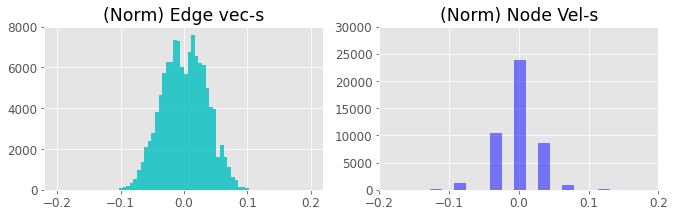

In [25]:
v_vel2 = torch.cat([d.y for d in hara_movs],0)
e_vec2 = torch.cat([d.edge_attr for d in hara_movs],0) # assumes non-directed graph, to convert to directed copy and
e_vec2 = torch.cat([e_vec2.view(-1,), -e_vec2.view(-1,)])
print('Hara movie dataset:\n'+10*"- ")
print(f'Edge vect-s (transform)\n\trange: [{e_vec2.min():4.3g} {e_vec2.max():4.3g}]; s.d.: {e_vec2.std():4.3g} ||'+
      f' median: {e_vec2.median():4.3g}; mean: {e_vec2.mean():4.3g};')
print(f'Node velocity (transform)\n\trange: [{v_vel2.min():4.3g} {v_vel2.max():4.3g}]; s.d.: {v_vel2.std():4.3g} ||'+
      f' median: {v_vel2.median():4.3g}; mean: {v_vel2.mean():4.3g};')

plt.figure(figsize=[23,3])
ax1 = plt.subplot(1,4,1)
ax1.hist(e_vec2.numpy(),bins=40,color='c',alpha=.8);
ax1.set_title('(Norm) Edge vec-s')
ax1.axis([-0.22,0.22,0,8000]);

ax2 = plt.subplot(1,4,2)
ax2.hist(v_vel2.view(-1,).numpy(),bins=51,color='b',alpha=.5);
ax2.set_title('(Norm) Node Vel-s');
ax2.axis([-0.2,0.2,0,30000]);